<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Install Libraries</span>

In [ ]:
# ! pip install seaborn

In [1]:
!pip install transformers

In [2]:
!pip install tensorflow
!pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.4 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [ ]:
# !pip install tqdm

In [ ]:
# !pip install nltk

In [ ]:
# !pip install textblob

In [3]:
!python -m textblob.download_corpora

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /usr/share/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /usr/share/nltk_

In [4]:
!pip install --upgrade tensorflow-io

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Import Libraries</span>

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import AutoTokenizer,TFBertModel
from textblob import Word

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# num_tpus_available = len(tf.config.experimental.list_physical_devices('TPU'))
# print("Num TPUs Available: ", num_tpus_available)
# assert num_tpus_available > 0

In [7]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)
assert num_gpus_available > 0

Num GPUs Available:  2


<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Load Data</span>

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Colab

In [ ]:
!gdown 1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW
!gdown 1-8TsrqTRFP-q9TM-6HinhO0ZVXFHq9TB
!gdown 1I9aPAvvYgQWdHGKtnd7IeTGXpx8vOm4h

In [ ]:
# Load data
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
map_data = pd.read_csv('title_brand.csv')

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Kaggle

In [8]:
# Load data
train_data = pd.read_csv('/kaggle/input/amazon-comments/train_data.csv', low_memory=False)
test_data = pd.read_csv('/kaggle/input/amazon-comments/test_data.csv')
map_data = pd.read_csv('/kaggle/input/amazon-comments/title_brand.csv')
path='/kaggle/working/'

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Preproccessing</span>

In [9]:
train_data.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,2,NaN,False,2016-11-11,A2OSUEZJIN7BI,0511189877,NaN,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn,1478822400
1,5,NaN,True,2016-06-06,A2NETQRG6JHIG7,0511189877,NaN,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,1465171200
2,4,NaN,True,2016-03-10,A12JHGROAX49G7,0511189877,NaN,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.,1457568000
3,5,NaN,True,2016-01-14,A1KV65E2TMMG6F,0511189877,NaN,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,1452729600
4,5,NaN,True,2016-10-20,A280POPEWI0NSA,0594459451,NaN,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,1476921600


In [10]:
test_data.head()

,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,NaN,True,2018-06-04,A20GGWE66JW9X2,B006Z394GM,{'Color:': ' FPS01-C'},Brian C Toner,The name and description of this device are mi...,The prize for most useless invention of all ti...,1528070400
1,NaN,True,2018-02-18,ARYJWXHEYHG9M,B005BE058W,"{'Size:': ' 1000W', 'Style:': ' G2'}",Snake,One of the molex connectors on the power suppl...,MELTED MOLEX CONNECTOR,1518912000
2,NaN,True,2018-01-20,A10LHZ7WFZ7HLL,B01DA0YCNC,NaN,Amazon Customer,Remote constantly disconnects/ Roku player fre...,Bricked on the regular,1516406400
3,NaN,True,2018-06-25,A11VN8EOHNLP72,B00FBJ4KYC,NaN,Jeremy Bray,I purchased this 4 year protection plan for a ...,DO NOT BUY!!!,1529884800
4,3.0,True,2016-08-17,A194Y8P8TVT7P9,B00P7G82TS,NaN,Mark,I bought one of these and have regretted it ev...,Nightmare - don't buy,1471392000


In [11]:
null_df = pd.concat([train_data.isna().sum() * 100 / len(train_data) , train_data.isna().sum()], axis=1)
null_df.columns=["percent", "num"]
null_df

,percent,num
overall,0.000000,0
vote,77.177499,647476
verified,0.000000,0
reviewTime,0.000000,0
reviewerID,0.000000,0
asin,0.000000,0
style,41.520173,348331
reviewerName,0.027058,227
reviewText,0.000000,0
summary,0.009059,76


In [12]:
test_data.isna().sum() * 100 / len(test_data) 

vote              75.335
verified           0.000
reviewTime         0.000
reviewerID         0.000
asin               0.000
style             42.480
reviewerName       0.020
reviewText         0.000
summary            0.010
unixReviewTime     0.000
dtype: float64

In [13]:
train_data2 = train_data.copy()
df_test = test_data.copy()

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Text Cleaning

In [14]:
lemmatizer = WordNetLemmatizer()
def text_cleaning(text):
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Normalizing Case Folding - Uppercase to Lowercase
    text = text.lower()
    
#     # StopWords
#     sw = stopwords.words('english')
#     text = " ".join(x for x in text.split() if x not in sw)

#     # Remove Rare Words
#     temp_df = pd.Series(' '.join(text).split()).value_counts()
#     drops = temp_df[temp_df <= 1].index
#     text = " ".join(x for x in text.split() if x not in drops)
# #     # Lemmatize
# #     text = " ".join([Word(word).lemmatize() for word in text.split()])
#     text = " ".join(lemmatizer.lemmatize(word) for word in text.split())

    return text

In [15]:
def text_preprocessing(df, dependent_var):
#     lemmatizer = WordNetLemmatizer()
    dataframe = df.copy()
    for i in tqdm(range(3)):
        if i == 0:
            # Remove non-alphanumeric characters and extra whitespace
            dataframe[dependent_var] = dataframe[dependent_var].fillna('').apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
        if i == 1:
            # Convert multiple whitespace characters to a single space
            dataframe[dependent_var] = dataframe[dependent_var].fillna('').apply(lambda x: re.sub(r'\s+', ' ', x))
        if i == 2:
            # Normalizing Case Folding - Uppercase to Lowercase
            dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
#         if i == 3:
#             # StopWords
#             sw = stopwords.words('english')
#             dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
#         if i == 3:
#             # Remove Rare Words
#             temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
#             drops = temp_df[temp_df <= 1]
#             dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))
#         if i == 4:
#             # Lemmatize
#             dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#             dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(lemmatizer.lemmatize(word) for word in x.split()))

    return dataframe

In [16]:
train_data2 = text_preprocessing(train_data2, "reviewText")
train_data2 = text_preprocessing(train_data2, "summary")

100%|██████████| 3/3 [00:08<00:00,  2.97s/it]


In [17]:
df_test = text_preprocessing(df_test, "reviewText")
df_test = text_preprocessing(df_test, "summary")

100%|██████████| 3/3 [00:00<00:00, 13.74it/s]


In [18]:
train_data2["reviewText"][8]

'it works i was skeptical about ordering it because the ratings werent great but short of buying a new nook or replacing it with a kindle it was the best shortterm option the original plugin part made a sizzling sound one night and stopped working my husband tried to plug the usb end into one of about usb to plugin wall chargers that we have around the house and none of them worked were assuming there must be some proprietary thing with the nook usb end that wont let you use generic wall chargers which really sucked because he couldnt use his nook for weeks if you are contemplating purchasing a nook it may be something to take into consideration'

In [19]:
# train_data2['reviewText'] = train_data['reviewText'].apply(text_cleaning)
# train_data2['summary'] = train_data['summary'].fillna('')
# train_data2['summary'] = train_data2['summary'].apply(text_cleaning)

In [20]:
# df_test['reviewText'] = df_test['reviewText'].apply(text_cleaning)
# df_test['summary'] = df_test['summary'].fillna('')
# df_test['summary'] = df_test['summary'].apply(text_cleaning)

In [21]:
df_train = train_data2.copy()

In [23]:
df_train['review_lengths'] = df_train['reviewText'].apply(len)

In [24]:
df_train['summary_lengths'] = df_train['summary'].apply(len)

In [25]:
df_train['review_lengths'].max()

28429

In [26]:
df_train['summary_lengths'].max()

352

In [27]:
df_train['overall'].value_counts() #/ len(df)

overall
5    461485
4    156514
1     82950
3     81239
2     56756
Name: count, dtype: int64

In [28]:
df_train[df_train['review_lengths'] < 600]['overall'].value_counts() #/ len(df)

overall
5    339960
4    103230
1     59378
3     54788
2     38393
Name: count, dtype: int64

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Replace reviewTexts where len(reviewText) > 600 and len(summary) < 100

In [29]:
large_review_indexes = df_train[df_train['review_lengths'] > 600].index

In [30]:
large_review_drop_indexes = df_train[(df_train['review_lengths'] > 600) & (df_train['summary_lengths'] < 100)].index

In [31]:
large_review_replace_indexes = df_train[(df_train['review_lengths'] > 600) & (df_train['summary_lengths'] >= 100)].index

In [32]:
len(large_review_indexes)

242633

In [33]:
len(large_review_replace_indexes)

7579

In [34]:
len(large_review_drop_indexes)

235054

In [35]:
len(large_review_drop_indexes) + len(large_review_replace_indexes)

242633

In [36]:
df_train = df_train.drop(large_review_drop_indexes)

In [37]:
df_train.loc[large_review_replace_indexes, 'reviewText'] = df_train.loc[large_review_replace_indexes, 'summary']

In [38]:
df_train['review_lengths'] = df_train['reviewText'].apply(len)

In [39]:
df_train['review_lengths'].min()

100

In [40]:
len(df_train)

603890

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Sampling</span>

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


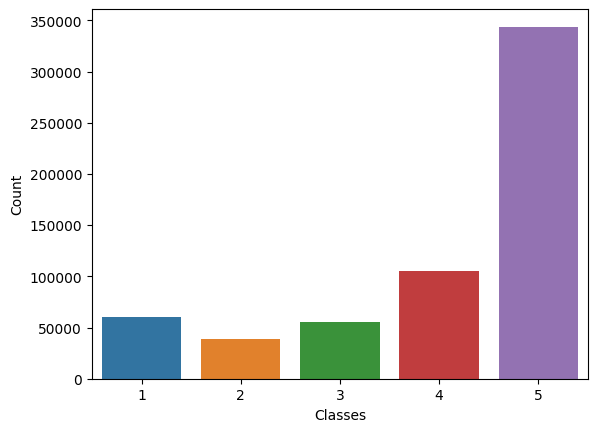

In [41]:
counts = df_train['overall'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [42]:
def sampling(df, num_target, each_class_size):
    # Identify the size of the smallest class
    min_class_size = min(each_class_size, df[num_target].value_counts().min())

    # Perform random sampling for each class to balance the sizes
    balanced_df = pd.concat([
        df[df[num_target] == sentiment].sample(min_class_size, replace=True)
        for sentiment in df[num_target].unique()
    ])

    # Shuffle the rows to randomize the order of samples
    balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
    return balanced_df

In [43]:
df_train_balanced = sampling(df_train, 'overall', 25000)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


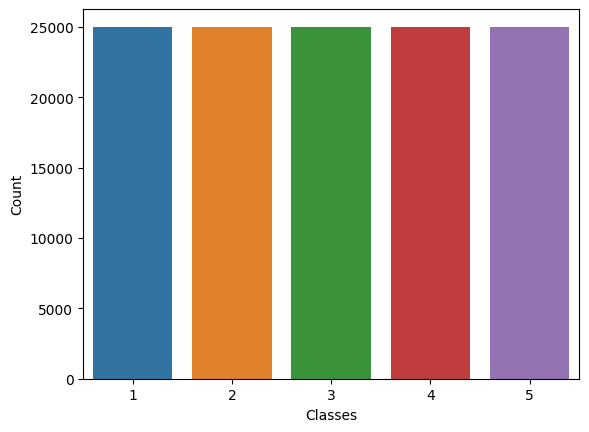

In [44]:
counts = df_train_balanced['overall'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Functions</span>

In [45]:
def save_model(model, tokenizer, filename, path=''):
    save_dir = os.path.join(path, filename)

    # Save tokenizer
    tokenizer.save_pretrained(save_dir +'/Tokenizer')

    # Save model
    model.save_pretrained(save_dir +'/Model')
    print("Saved model to ", save_dir )
    
def load_model(model, tokenizer, filename, path=''):
    load_dir = os.path.join(path, filename)
    
    # Load tokenizer
    tokenizer = tokenizer.from_pretrained(load_dir +'/Tokenizer')

    # Load model
    model = model.from_pretrained(load_dir +'/Model')
    
    return model, tokenizer

In [46]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['balanced_accuracy'])
    plt.plot(history.history['val_balanced_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

In [47]:
def f1_micro(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1

def f1_micro_onehot(y_true, y_pred):
    y_true = K.cast(K.argmax(y_true, axis=-1), dtype='float32')
    y_pred = K.cast(K.argmax(y_pred, axis=-1), dtype='float32')

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Split Data</span>

In [48]:
# Training data
Reviews = df_train_balanced['reviewText']
labels = df_train_balanced['overall']
# Test data
test_reviews = df_test['reviewText']

In [49]:
train_reviews, validation_reviews, train_labels, validation_labels = train_test_split(Reviews, labels, test_size=0.2, random_state=42)

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Try Models</span>

<span style="display: block; padding: 1px; border-bottom: 2px solid green; color: green; font-size: 28px;">Model 1</span>

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Tokenize

In [50]:
tokenizer1 = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [51]:
max_len= 128
# Tokenize and encode the sentences
train_encoded = tokenizer1.batch_encode_plus(train_reviews.tolist(),
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
print("train_encoded encoded")
val_encoded = tokenizer1.batch_encode_plus(validation_reviews.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
print("val_encoded encoded")
test_encoded = tokenizer1.batch_encode_plus(test_reviews.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
print("test_encoded encoded")

train_encoded encoded
val_encoded encoded
test_encoded encoded


In [52]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer1.decode(train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',train_encoded['attention_mask'][k])
print('\nLabels -->>',labels[k])


Training Comments -->> these cases are great replacements cases for wii games especially if youre a collector and want to replace that ugly beat up game stop case they are as good as the original wii cases imo there was a slight issue with a few of the cases but the seller was very responsive and we worked it out thank you

Input Ids -->>
 tf.Tensor(
[  101  1996  3543 11687  2001 12181  2100  2018  2053  3417  2000  5587
  9380  3298  2061  2017  2024  5881  2007  2019  6327  3131  2009  2056
  2009  2018  3645  2006  2009  2070 12181  2442  2031  9725  2009  2000
  2003  2200 14480  2145  2513   102     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0   

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Encode Labels 

In [53]:
train_labels_cat = to_categorical(train_labels - 1)
validation_labels_cat = to_categorical(validation_labels - 1)

In [54]:
train_labels_cat

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Train Model

In [55]:
num_classes = 5

# Intialize the model
model1 = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = CategoricalCrossentropy(from_logits=True)
balanced_accuracy = CategoricalAccuracy('balanced_accuracy')
metric = [balanced_accuracy]
# Compile the model with an appropriate optimizer, loss function, and metrics
model1.compile(optimizer=optimizer, loss=loss, metrics=[metric])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy',
                                               min_delta=0,
                                               patience=3,
                                               mode='max',
                                               restore_best_weights=True)

# Train the model
history1 = model1.fit(
    [train_encoded['input_ids'], train_encoded['token_type_ids'], train_encoded['attention_mask']], 
    train_labels_cat,
    validation_data=(
        [val_encoded['input_ids'], val_encoded['token_type_ids'], val_encoded['attention_mask']], 
        validation_labels_cat
    ),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping]
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
3125/3125 [==============================] - 2926s 922ms/step - loss: 0.9659 - balanced_accuracy: 0.5783 - val_loss: 0.8754 - val_balanced_accuracy: 0.6168
Epoch 2/20
3125/3125 [==============================] - 2884s 923ms/step - loss: 0.7717 - balanced_accuracy: 0.6741 - val_loss: 0.8415 - val_balanced_accuracy: 0.6495
Epoch 3/20
3125/3125 [==============================] - 2885s 923ms/step - loss: 0.6006 - balanced_accuracy: 0.7563 - val_loss: 0.8352 - val_balanced_accuracy: 0.6741
Epoch 4/20
3125/3125 [==============================] - 2885s 923ms/step - loss: 0.4488 - balanced_accuracy: 0.8255 - val_loss: 0.9044 - val_balanced_accuracy: 0.6804
Epoch 5/20
3125/3125 [==============================] - 2884s 923ms/step - loss: 0.3373 - balanced_accuracy: 0.8711 - val_loss: 0.9990 - val_balanced_accuracy: 0.6880
Epoch 6/20
3125/3125 [==============================] - 2883s 923ms/step - loss: 0.2588 - balanced_accuracy: 0.9042 - val_loss: 1.1241 - val_balanced_accuracy: 0.682

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Evaluation on Validation Data

In [65]:
predicted_val = model1.predict([val_encoded['input_ids'], val_encoded['token_type_ids'], val_encoded['attention_mask']])
logits_val = predicted_val.logits
y_val_predicted = tf.argmax(logits_val, axis=1)
y_val_predicted = y_val_predicted.numpy() + 1

y_true = validation_labels
print(f"F1_micro: {f1_score(y_true, y_val_predicted, average='micro')}")

782/782 [==============================] - 221s 283ms/step
F1_micro: 0.68796


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [66]:
print("Classification Report: \n", classification_report(y_true, y_val_predicted, labels=list(range(0,6))))

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.78      0.74      0.76      4992
           2       0.63      0.67      0.65      5040
           3       0.60      0.65      0.63      4990
           4       0.64      0.64      0.64      5045
           5       0.81      0.74      0.77      4933

   micro avg       0.69      0.69      0.69     25000
   macro avg       0.58      0.57      0.58     25000
weighted avg       0.69      0.69      0.69     25000



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Plot History

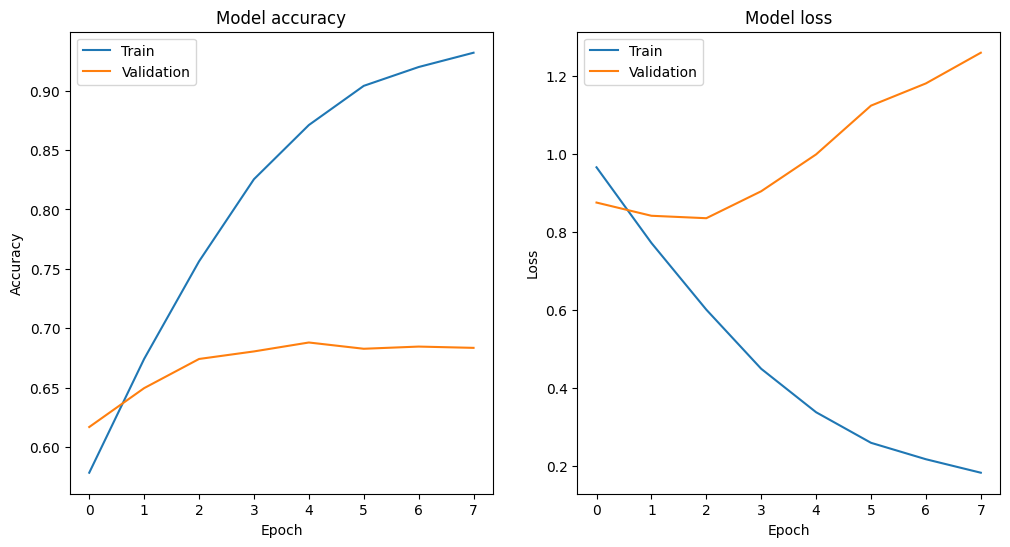

In [67]:
plot_history(history1)

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Evaluation on Test Data

In [68]:
predicted_test = model1.predict([test_encoded['input_ids'], test_encoded['attention_mask']])
logits_test = predicted_test.logits

y_test_predicted = tf.argmax(logits_test, axis=1)
y_test_predicted = y_test_predicted.numpy() + 1

625/625 [==============================] - 178s 285ms/step


In [69]:
df = pd.DataFrame({'predicted': y_test_predicted})

df.to_csv('/kaggle/working/q2_submission_model1_125.csv', index=False)
df.head()

,predicted
0,2
1,2
2,2
3,1
4,1


In [70]:
unique_values, counts = np.unique(y_test_predicted, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count} times")

1: 3032 times
2: 4605 times
3: 4970 times
4: 4035 times
5: 3358 times


In [ ]:
# save model
save_model(model1, tokenizer1,
           filename='Bert_model1', 
           path=path)

<span style="display: block; padding: 1px; border-bottom: 2px solid green; color: green; font-size: 28px;">Model 2</span>

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Tokenize

In [ ]:
tokenizer2 = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
max_len = 128
# Tokenize and encode the sentences
train_encodings = tokenizer2(train_reviews.tolist(),
                            padding=True, 
                            truncation=True,
                            max_length = max_len,
                            return_tensors='tf')
val_encodings = tokenizer2(validation_reviews.tolist(),
                            padding=True, 
                            truncation=True,
                            max_length = max_len,
                            return_tensors='tf')
test_encodings = tokenizer2(test_reviews.tolist(),
                            padding=True, 
                            truncation=True,
                            max_length = max_len,
                            return_tensors='tf')


<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Train Model

In [ ]:
num_classes = 5

# Intialize the model
model2 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = CategoricalCrossentropy(from_logits=True)
balanced_accuracy = CategoricalAccuracy('balanced_accuracy')
metric = [balanced_accuracy]
# Compile the model with an appropriate optimizer, loss function, and metrics
model2.compile(optimizer=optimizer, loss=loss, metrics=[metric])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy',
                                               min_delta=0,
                                               patience=3,
                                               mode='max',
                                               restore_best_weights=True)

# Train the model
batch_size = 32
history2 = model2.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']], 
    train_labels_cat,
    validation_data=(
        [val_encodings['input_ids'], val_encodings['attention_mask']], 
        validation_labels_cat
    ),
    batch_size=32,
    epochs=15,
    callbacks=[early_stopping]
)

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Evaluation on Validation Data

In [ ]:
predicted_val = model2.predict([val_encodings['input_ids'], val_encodings['attention_mask']])
logits_val = predicted_val.logits
y_val_predicted = tf.argmax(logits_val, axis=1)
y_val_predicted = y_val_predicted.numpy() + 1

y_true = validation_labels
print(f"F1_micro: {f1_score(y_true, y_val_predicted, average='micro')}")

In [ ]:
print("Classification Report: \n", classification_report(y_true, y_val_predicted, labels=list(range(0,6))))

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Plot History

In [ ]:
plot_history(history2)

In [ ]:
# save model
save_model(model2, tokenizer2,
           filename='Bert_model2', 
           path=path)

<span style="display: block; padding: 1px; border-bottom: 2px solid green; color: green; font-size: 28px;">Model 3</span>

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Prepare Data

In [ ]:
train_reviews, validation_reviews, train_labels, validation_labels = train_test_split(Reviews, labels, test_size=0.3, random_state=42)

In [ ]:
df_train_val_balanced = df_train_balanced.copy()

In [ ]:
df_train_val_balanced = df_train_balanced[['reviewText', 'overall']]
df_train_val_balanced.columns = ['Input', 'Sentiment']
df_train_val_balanced.head()

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(df_train_val_balanced[['Input']], df_train_val_balanced['Sentiment'], random_state=42)

In [ ]:
df_test2 = df_test[['reviewText']]
df_test2.columns = ['Input']
df_test2.head()

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Encode Label

In [ ]:
y_train_cat = to_categorical(y_train - 1)
y_validation_cat = to_categorical(y_validation - 1)

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Tokenize

In [ ]:
tokenizer3 = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
max_len = 128

x_train = tokenizer3(
    text=X_train.Input.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_validation = tokenizer3(
    text=X_validation.Input.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_test = tokenizer3(
    text=df_test2.Input.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Train Model

In [ ]:
num_classes = 5

bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

max_len = 128

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.Flatten()(embeddings)
out = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(out)
out = tf.keras.layers.Dropout(0.2)(out)
out = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(out)
y = Dense(5,activation = 'softmax')(out)

model3 = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model3.layers[2].trainable = True
model3.summary()

optimizer = Adam(learning_rate=5e-05, epsilon=1e-08, clipnorm=1.0)
# Set loss and metrics
loss = CategoricalCrossentropy(from_logits = True)
balanced_accuracy = CategoricalAccuracy('balanced_accuracy')
metric = [balanced_accuracy]
# Compile the model
model3.compile(optimizer=optimizer, loss=loss, metrics=metric)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy',
                                               min_delta=0,
                                               patience=2,
                                               mode='max',
                                               restore_best_weights=True)

history3 = model3.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train_cat,
    validation_data = (
    {'input_ids':x_validation['input_ids'],'attention_mask':x_validation['attention_mask']},
        y_validation_cat
    ),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

<span style="color:green; border-bottom: 2px solid green;font-size: 24px;">Evaluation on Validation Data

In [ ]:
predicted_val = model3.predict([val_encodings['input_ids'], val_encodings['attention_mask']])
logits_val = predicted_val.logits
y_val_predicted = tf.argmax(logits, axis=1)
y_val_predicted = y_val_predicted.numpy() + 1

y_true = validation_labels
print(f"F1_micro: {f1_score(y_true, y_val_predicted, average='micro')}")

In [ ]:
# save model
save_model(model3, tokenizer3,
           filename='Bert_model3', 
           path=path)

<span style="display: block; background-color: lightgray; padding: 10px; border-bottom: 2px solid blue; color: blue; font-size: 32px;">Test on best Model (Model 1)</span>

In [ ]:
predicted_test = model1.predict([test_encoded['input_ids'], test_encoded['attention_mask']])
logits_test = predicted_test.logits

y_test_predicted = tf.argmax(logits_test, axis=1)
y_test_predicted = y_test_predicted.numpy() + 1

In [ ]:
df = pd.DataFrame({'predicted': y_test_predicted})

df.to_csv('/kaggle/working/q2_submission.csv', index=False)
df.head()